In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.01 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = 1e-3 # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 2))), 0.01, 0, 0.1262135922330097, 2000, 500, true, 50, 1, 0.001f0, 1.0f0, MVHistory{ValueHistories.History}, "rerr")

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)

loss: 0.90187573
reconstruction error: 0.86419237
KL: 0.22741929

loss: 0.040313512
reconstruction error: 0.026672706
KL: 1.0969262

loss: 0.024394903
reconstruction error: 0.012923014
KL: 1.271138

loss: 0.020014545
reconstruction error: 0.0071584117
KL: 1.276136

loss: 0.016033225
reconstruction error: 0.0044135884
KL: 1.2537799

loss: 0.019053183
reconstruction error: 0.008328503
KL: 1.273793



0.025079716f0

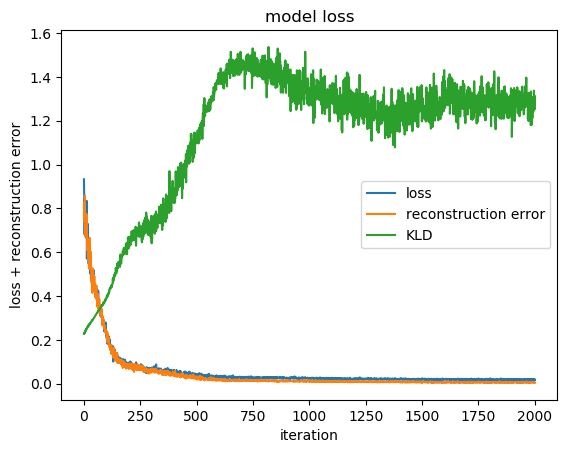

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 2×90 Array{Float32,2}:
 0.806636  0.812836  0.789343  0.776663  …  0.071447  0.0348662  0.0137143
 0.82448   0.80421   0.788762  0.778647     0.929405  0.933101   0.997517 

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

What are the parameters of $q(z|x)$?

In [8]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float32,2}:
  1.11337    1.10806    1.12577   …  -1.20539   -1.19536   -1.15526 
 -0.145454  -0.136186  -0.148178      0.136274   0.144238   0.141768

In [9]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.345412  0.342943  0.345813  0.345175  …  0.219394  0.215119  0.219584
 1.047     1.05512   1.04845   1.05913      0.914633  0.924457  0.921903

What do the generated samples look like?

In [10]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 1.27992   1.46825  0.860195   0.784079  …  -1.03649   -1.25098   -0.971758
 2.51385  -1.39463  2.30636   -0.238617     -0.185448   0.536729   2.30427 

In [11]:
# predict labels on testing data
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0

In [12]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 9
  tn = 90
  fp = 0
  fn = 4
precision: 1.0
f1score: 0.8181818181818182
recall: 0.6923076923076923
false positive rate: 0.0
equal error rate: 0.15384615384615385

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 9
  tn = 90
  fp = 0
  fn = 4
precision: 1.0
f1score: 0.8181818181818182
recall: 0.6923076923076923
false positive rate: 0.0
equal error rate: 0.15384615384615385


In [13]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

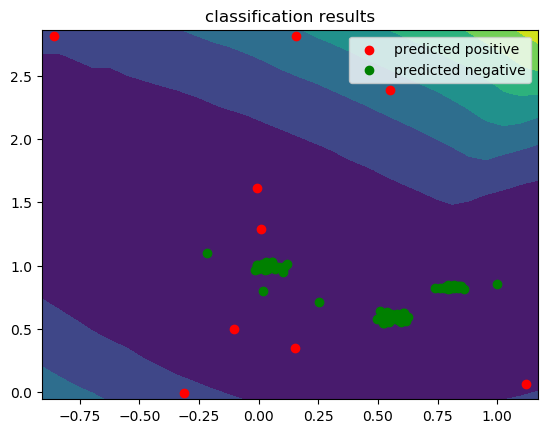

In [14]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

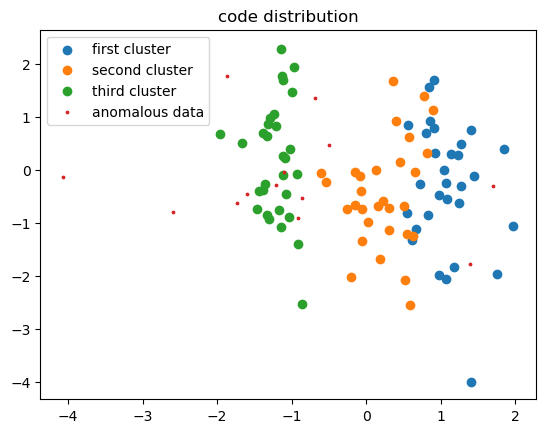

In [15]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

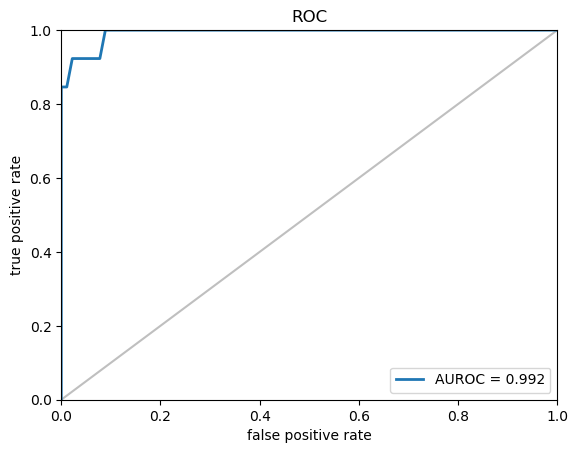

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()